In [109]:
#import the standard libraries first and the standard ipython magic functions

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob, os, sys, pickle, random

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
cifar_dir = 'cifar-10-batches-py'
batchfiles = glob.glob(cifar_dir+'/*_batch*')
data_train = {}
data_train['data'] = []
data_train['labels'] = []
for file in batchfiles:
    if 'test' in file:
        data_batch = pickle.load(open(file,'rb'), encoding='bytes')
        data_test = {}
        data_test['data'] = data_batch[b'data']
        data_test['labels'] = data_batch[b'labels']
    else:
        data_batch = pickle.load(open(file,'rb'), encoding='bytes')
        data_train['data'].append(data_batch[b'data'])
        data_train['labels'].append(data_batch[b'labels'])
data_train['data'] = np.concatenate(data_train['data'],axis=0)
data_train['labels'] = np.concatenate(data_train['labels'],axis=0)

meta_data = pickle.load(open(cifar_dir+'/batches.meta','rb'), encoding='bytes')
meta_data = [item.decode('utf-8') for item in meta_data[b'label_names']]

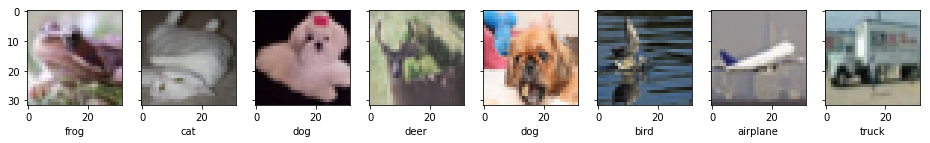

In [52]:
idxes = np.random.choice(50000,8,replace=False)
images = data_train['data'][idxes]

f, ax = plt.subplots(1,8, sharey = True, figsize=(16,2))
for i in range(8):
    ax[i].imshow(np.resize(images[i],[3,32,32]).transpose(1,2,0))
    ax[i].set_xlabel(meta_data[data_train['labels'][idxes[i]]])
plt.show()

In [113]:
class CIFAR10Dataset(Dataset):
    
    def __init__(self, data):
        self.data = data['data']
        self.labels = data['labels']
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {'111':idx,'data':np.resize(self.data[idx],[3,32,32]).transpose(1,2,0),
                'label':self.labels[idx]}
    
dataset = CIFAR10Dataset(data_train)
torch.cuda.manual_seed_all(42)
torch.manual_seed(412)
np.random.seed(42)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers = 3)
loader = enumerate(dataloader)
print(next(loader)[1]['111'])
print(next(loader)[1]['111'])
print(next(loader)[1]['111'])
print(next(loader)[1]['111'])



tensor([ 9669, 38326, 31200, 26869])
tensor([ 9189, 26805, 47402,  4690])
tensor([41497, 26777,  1969,  5558])
tensor([16879, 10609,  2518,  7817])
